In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

In [2]:
# better graphs
sns.set()

0.0070396251811905425

In [3]:
# utility functions
def delta(t, tau, A, k):
    return 0.01 * np.random.randn()
    Hval = A / (1 + np.exp(-k * (t - tau)))
    Dval = k * Hval * (1 - Hval / A)
    return Dval

def hill(t, tau, A, k):
    Hval = A / (1 + np.exp(-k * (t - tau)))
    return Hval

def maxfunc(x, a, ep):
    maxval = (x + np.sqrt(x**2 + ep)) / 2
    return maxval

# model
def dalla_man_2014(t, u, p, bcs, D, uI, uG):
    x = [0, *u]

    # --- arbitrary parameters ---
    BW = 70 # body weight

    # --- parameters ---
    (
        Vg,
        k1,
        k2,
        VI,
        m1,
        m2,
        m4,
        m5,
        m6,
        HEb,
        kp1,
        kp2,
        kp3,
        kp4,
        ki,
        kmax,
        kmin,
        kabs,
        kgri,
        f,
        a,
        b,
        c,
        d,
        Fcns,
        Vm0,
        Vmx,
        Km0,
        P2u,
        K,
        Alpha,
        Beta,
        Gamma,
        ke1,
        ke2,
        kd,
        ka1,
        ka2,
        Delta,
        Sigma,
        n,
        Zeta,
        Rho,
        kH,
        Hb,
        kh1,
        kh2,
        kh3,
    ) = p

    # --- dependent parameters ---
    HE = HEb
    m3 = HE * m1 / (1 - HE)

    # --- basal states ---
    _, _, _, _, _, _, Ib, IIRb, _, _, kp1, Km0, Hb, SRHb, Gth, _,  _,  Ith, _, _, _ = bcs

    # --- states ---
    ## glucose subsystem
    Gp = x[1]
    Gt = x[2]
    G = Gp / Vg

    ## insulin subsystem
    Il = x[3]
    Ip = x[4]
    I = Ip / VI

    ## endogenous glucose production
    I1 = x[5]
    Id = x[6]

    ## glucose rate of appearance
    Qsto1 = x[7]
    Qsto2 = x[8]
    Qgut = x[9]
    Ra = f * kabs * Qgut / BW

    ## glucose utilization
    X = x[10]
    Uii = Fcns
    Uid = (Vm0 + Vmx * X) * Gt / (Km0 + Gt)

    ## glucagon kinetics
    SRsH = x[11]
    H = x[12]
    XH = x[13]

    ## endogeneous glucagon production
    EGP = kp1 - kp2 * Gp - kp3 * Id + Zeta * XH

    ## glucose renal excretion
    E = 0 if Gp <= ke2 else ke1 * (Gp - ke2)

    ## subcutaneous insulin infusion
    Isc1 = x[14]
    Isc2 = x[15]
    Rai = ka1 * Isc1 + ka2 * Isc2

    ## subcataneous glucagon
    Hsc1 = x[16]
    Hsc2 = x[17]
    Rah = kh3 * Hsc2

    # --- dynamics ---
    ## glucose subsystem
    dGp = EGP + Ra - Uii - E - k1 * Gp + k2 * Gt
    dGt = -Uid + k1 * Gp - k2 * Gt
    dG = dGp / Vg

    ## insulin subsystem
    dIl = -(m1 + m3) * Il + m2 * Ip
    dIp = -(m2 + m4) * Ip + m1 * Il + Rai

    ## endogenous glucose production
    dI1 = -ki * (I1 - I)
    dId = -ki * (Id - I)

    ## glucose rate of appearance
    Qsto = Qsto1 + Qsto2
    kempt = kmin + (kmax - kmin) / 2 * (
        np.tanh(5 / (2 * D * (1 - b)) * (Qsto - b * D))
        - np.tanh(5 / (2 * D * c) * (Qsto - c * D))
        + 2
    )
    dQsto1 = -kgri * Qsto1 + D * delta(t, 60, 1, 4)
    dQsto2 = -kempt * Qsto2 + kgri * Qsto1
    dQgut = -kabs * Qgut + kempt * Qsto2

    ## glucose utilization
    dX = -P2u * (X - I + Ib)

    ## glucagon subsystem
    SRdH = Delta * maxfunc(-dG, 0, 0.0001)
    SRH = SRsH + SRdH
    dSRsH = -Rho * (
        SRsH
        - maxfunc(
            (Sigma * (Gth - G) / (maxfunc(I - Ith, 0, 0.0001) + 1)) + SRHb, 0, 0.0001
        )
    )
    dH = -n * H + SRH + Rah
    dXH = -kH * XH + kH * maxfunc(H - Hb, 0, 0.0001)

    ## subcatenous insulin
    dIsc1 = -(kd + ka1) * Isc1 + IIRb + (1 / 78) * uI * 6944.4 * delta(t, 30, 1, 4)
    dIsc2 = kd * Isc1 - ka2 * Isc2

    ##  subcatenous glucagon
    dHsc1 = -(kh1 + kh2) * Hsc1 + (1 / 78) * uG * 1e6 * delta(t, 150, 1, 4)
    dHsc2 = kh1 * Hsc1 - kh3 * Hsc2

    return [dGp, dGt, dIl, dIp, dI1, dId, dQsto1, dQsto2, dQgut, dX, dSRsH, dH, dXH, dIsc1, dIsc2, dHsc1, dHsc2]

In [4]:
# nominal parameters
Vg = 1.88
k1 = 0.065
k2 = 0.079
VI = 0.05
m1 = 0.19
m2 = 0.484
m4 = 0.194
m5 = 0.0304
m6 = 0.6471
HEb = 0.6
kp1 = 2.7735
kp2 = 0.0021
kp3 = 0.009
kp4 = 0.0618
ki = 0.0079
kmax = 0.0558
kmin = 0.008
kabs = 0.057
kgri = 0.0558
f = 0.9
a = 0.000013
b = 0.82
c = 0.00236
d = 0.01
Fcns = 1
Vm0 = 2.5
Vmx = 0.0047
Km0 = 225.59
P2u = 0.0331
K = 2.3
Alpha = 0.05
Beta = 0.11
Gamma = 0.5
ke1 = 0.0005
ke2 = 339
kd = 0
ka1 = 0
ka2 = 0

Delta = 0.682
Sigma = 1.093
n = 0.15
Zeta = 0.009
Rho = 0.57
kH = 0.16
Hb = 93
kh1 = 0.0164
kh2 = 0.0018
kh3 = 0.0182

p = [Vg, k1, k2, VI, m1, m2, m4, m5, m6, HEb, kp1, kp2, kp3, kp4, ki, kmax, kmin, kabs, kgri, f, a, b, c, d, Fcns, Vm0, Vmx, Km0, P2u, K, Alpha, Beta, Gamma, ke1, ke2, kd, ka1, ka2, Delta, Sigma, n, Zeta, Rho, kH, Hb, kh1, kh2, kh3]

In [5]:
# basal conditions
Gb = 130
Sb = 0
IIRb = 0
m3 = HEb * m1 / (1 - HEb)
Ipb = IIRb / (m2 + m4 - (m1 * m2) / (m1 + m3))
Ilb = Ipb * (m2 / (m1 + m3))
Ib = Ipb / VI
Ipob = 0
EGPb = 2.4
Gpb = Gb * Vg
Gtb = (Fcns - EGPb + k1 * Gpb) / k2
Isc1ss = 0 # IIRb / (kd + ka1)
Isc2ss = 0 # kd * Isc1ss / ka2
kp1 = EGPb + kp2 * Gpb + kp3 * Ib
Km0 = (Vm0 * Gtb) / (EGPb - Fcns) - Gtb
SRHb = n * Hb
Gth = Gb
SRsHb = max(Sigma * (Gth - Gb) + SRHb, 0)
XHb = 0
Ith = Ib
IGRb = 0
Hsc1ss = IGRb / (kh1 + kh2)
Hsc2ss = kh1 * Hsc1ss / kh3

bcs = [Gb, Gpb, Gtb, Ilb, Ipb, Ipob, Ib, IIRb, Isc1ss, Isc2ss, kp1, Km0, Hb, SRHb, Gth, SRsHb, XHb, Ith, IGRb, Hsc1ss, Hsc2ss]

In [6]:
# initial conditions
Gp0 = Gpb
Gt0 = Gtb
Il0 = Ilb
Ip0 = Ipb
I10 = Ib
Id0 = Ib
Qsto10 = 0
Qsto20 = 0
Qgut0 = 0
X0 = 0
SRsH0 = SRsHb
H0 = Hb
XH0 = 0
Isc10 = Isc1ss
Isc20 = Isc2ss
Hsc10 = Hsc1ss
Hsc20 = Hsc2ss

u0 = [Gp0, Gt0, Il0, Ip0, I10, Id0, Qsto10, Qsto20, Qgut0, X0, SRsH0, H0, XH0, Isc10, Isc20, Hsc10, Hsc20]

In [7]:
# timespan
t_span = (0, 5000)
t_eval = np.linspace(*t_span, 1000)

In [8]:
D = 50
uG = 0.0
uI = 0.0

In [17]:
sol = solve_ivp(dalla_man_2014, t_span, u0, t_eval=t_eval, args=(p, bcs, D, uI, uG), method="BDF")

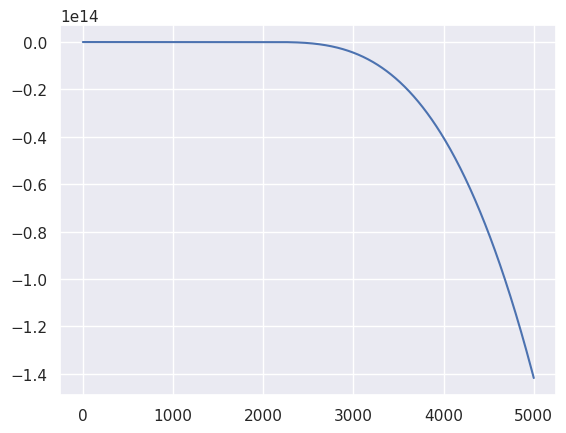

In [18]:
plt.plot(sol.t, sol.y[0, :])
plt.show()